# **IMPORTADO DE MÓDULOS/FUNCIONES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

2024-05-13 17:40:10.026967: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 17:40:10.050585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 17:40:10.429675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

In [3]:
from functions import momentos, gauss, gauss_fit, pulso, delay_pulse_pair, get_mean_pulse_from_set, get_closest, move_to_reference

# **PREPROCESSING**

In [4]:
start = 50
stop = 80
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28[:,start:stop,:]
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 30
Time step: 0.20
New number of time points: 240
New time step: 0.0250


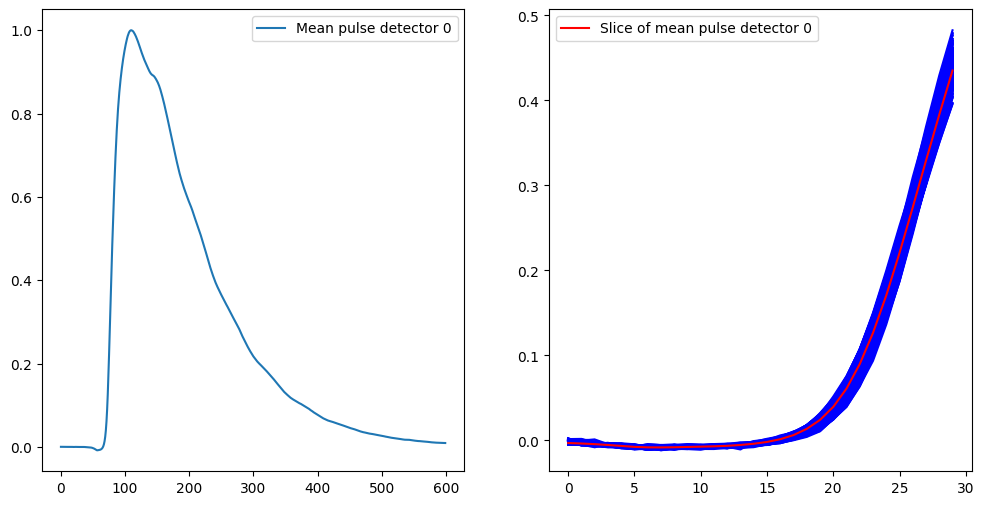

In [10]:
mean_dec0 = get_mean_pulse_from_set(V55, channel=0)
delay, moved_pulses = move_to_reference(mean_dec0, V55, start = start, stop = stop, max_delay = 15, channel = 0)

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(mean_dec0, label = 'Mean pulse detector 0')
plt.legend()
plt.subplot(122)
for i in range(moved_pulses.shape[0]):
    plt.plot(moved_pulses[i,:], 'b-')
plt.plot(mean_dec0[start:stop], 'r-', label = 'Slice of mean pulse detector 0')
plt.legend()

In [9]:
#--------------------------------Interpolar pulsos reales---------------------------------
interp_func_V28 = interp1d(tiempo,V28[:,start:stop,:],  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55[:,start:stop,:],  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82[:,start:stop,:],  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)

interp_func_mean_dec0 = interp1d(tiempo, mean_dec0[start:stop],  kind='cubic')
mean_dec0 = interp_func_mean_dec0(tiempo_new)


In [12]:
Num_casos = 1000
Ntest = int(0.1*Num_casos)
Nc = 2

t_shift = 8 #In time steps 
t0 = 65 + np.random.randint(5, size = Num_casos) 
tt=np.linspace(0,600,600)   #time step of 0.2ns

# **DETECTOR 0**

In [13]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 25
tau_drop_dec0 = 150

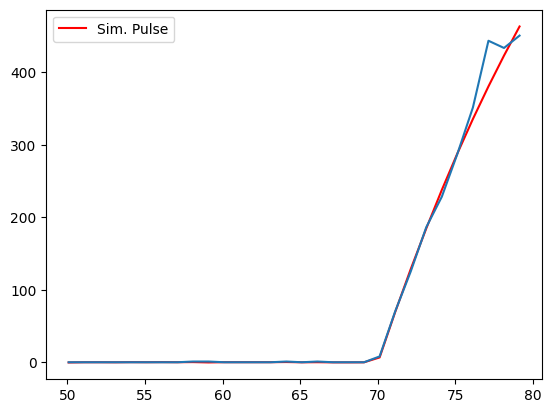

In [15]:
pulso_original = pulso(tt, 70, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
pulso_noisy = pulso_original + np.random.poisson(abs(pulso_original)*1000)



plt.plot(tt[start:stop],1000*pulso_original[start:stop],'r-', label = 'Sim. Pulse')
#plt.plot(tt[start:stop],V55[0,start:stop,0],'b-', label = 'Real pulse')
plt.plot(tt[start:stop], pulso_noisy[start:stop])
plt.legend()

In [16]:
#------------------------------------------- Create train set ---------------------------
INPUT_dec0 = np.zeros((Num_casos,Nt_new,Nc))

for i in range(Num_casos):
  centro = t0[i]
  noise = np.random.normal(scale=1e-4, size=t_shift)
  
  PULSO = pulso(tt,centro, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  interp_func = interp1d(tiempo,PULSO[start:stop], kind='cubic')
  PULSO = interp_func(tiempo_new)
  
  INPUT_dec0[i,:,0] = PULSO
  INPUT_dec0[i,:,1] = np.roll(PULSO, t_shift)
  INPUT_dec0[i,0:t_shift,1] = noise


trainX_dec0, REF_train_dec0 = delay_pulse_pair(INPUT_dec0, new_time_step, t_shift = t_shift, delay_steps = 32)

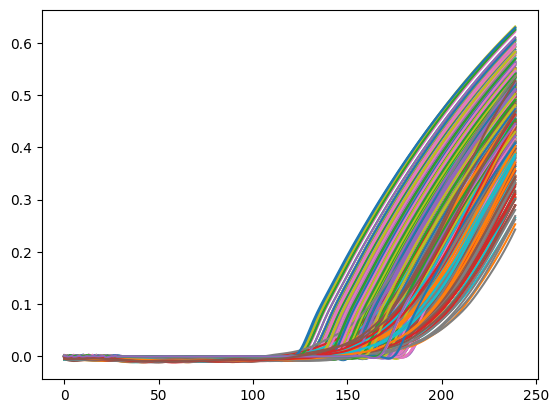

In [9]:
for i in range(new_V55.shape[0]):
  plt.plot(trainX_dec0[i,:,0])
  plt.plot(new_V55[i,:,0])

In [10]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)

NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print('Min dec0 =', min_dec0)
print('Max dec0 =', max_dec0)

(1000, 12, 2) NM = 12
Min dec0 = 0.41774530078063665
Max dec0 = 42.66629283145285


# **DETECTOR 1**

In [11]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec1 = 20
tau_drop_dec1 = 150

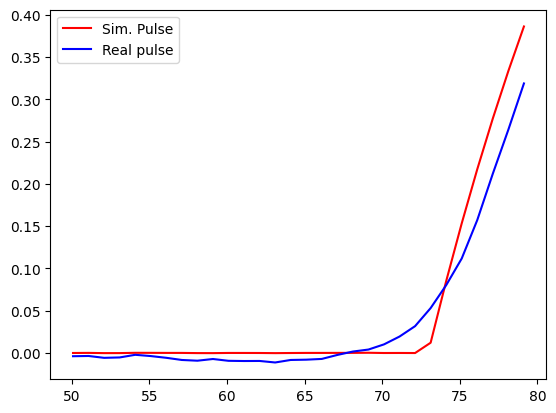

In [12]:
pulso_original = pulso(tt, 73, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)

plt.plot(tt[start:stop],pulso_original[start:stop],'r-', label = 'Sim. Pulse')
plt.plot(tt[start:stop],V55[0,start:stop,1],'b-', label = 'Real pulse')
plt.legend()

In [13]:
#------------------------------------------- Create train set ---------------------------
INPUT_dec1 = np.zeros((Num_casos,Nt_new,Nc))

for i in range(Num_casos):
  centro = t0[i]
  noise = np.random.normal(scale=1e-4, size=t_shift)
  
  PULSO = pulso(tt,centro, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)
  interp_func = interp1d(tiempo,PULSO[start:stop], kind='cubic')
  PULSO = interp_func(tiempo_new)
  
  INPUT_dec1[i,:,0] = PULSO
  INPUT_dec1[i,:,1] = np.roll(PULSO, t_shift)
  INPUT_dec1[i,0:t_shift,1] = noise


trainX_dec1, REF_train_dec1 = delay_pulse_pair(INPUT_dec1, new_time_step, t_shift = t_shift, delay_steps = 32)

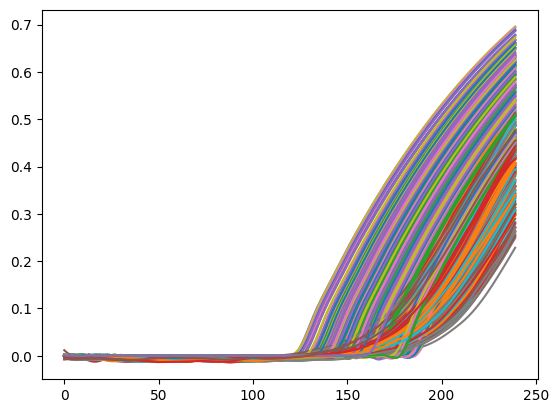

In [14]:
for i in range(new_V55.shape[0]):
  plt.plot(trainX_dec1[i,:,0])
  plt.plot(new_V55[i,:,1])

In [15]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print('Min dec1 =', min_dec1)
print('Max dec1 =', max_dec1)

(1000, 12, 2) NM = 12
Min dec1 = 0.4750803667517437
Max dec1 = 47.48321035282098


# **CREATE TEST SET** 

In [16]:
#------------------------------------------- Create test set ---------------------------
Test_55 = np.zeros((Ntest,Nt_new,Nc))
Test_28 = np.zeros((Ntest,Nt_new,Nc))
Test_82 = np.zeros((Ntest,Nt_new,Nc))
t_shift_test = 8


for i in range(Ntest):
  centro = t0[i]
  PULSO_dec0 = pulso(tt, centro, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  PULSO_dec1 = pulso(tt, centro, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)
  
  interp_func_dec0 = interp1d(tiempo,PULSO_dec0[start:stop], kind='cubic')
  interp_func_dec1 = interp1d(tiempo,PULSO_dec1[start:stop], kind='cubic')
  PULSO_dec0 = interp_func(tiempo_new)
  PULSO_dec1 = interp_func(tiempo_new)
  
  Test_55[i,:,0] = PULSO_dec0
  Test_55[i,:,1] = PULSO_dec1

for i in range(Ntest):
  centro = t0[i]
  noise = np.random.normal(scale=1e-4, size = t_shift_test)
  PULSO_dec0 = pulso(tt, centro, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  PULSO_dec1 = pulso(tt, centro, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)
 
  interp_func_dec0 = interp1d(tiempo,PULSO_dec0[start:stop], kind='cubic')
  interp_func_dec1 = interp1d(tiempo,PULSO_dec1[start:stop], kind='cubic')
  PULSO_dec0 = interp_func(tiempo_new)
  PULSO_dec1 = interp_func(tiempo_new)
  
  Test_28[i,:,0] = PULSO_dec0
  Test_28[i,:,1] = np.roll(PULSO_dec1, t_shift_test)
  Test_28[i,0:t_shift_test,1] = noise

for i in range(Ntest):
  centro = t0[i]
  noise = np.random.normal(scale=1e-4, size = t_shift_test)
  PULSO_dec0 = pulso(tt, centro, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = True)
  PULSO_dec1 = pulso(tt, centro, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)

  interp_func_dec0 = interp1d(tiempo,PULSO_dec0[start:stop], kind='cubic')
  interp_func_dec1 = interp1d(tiempo,PULSO_dec1[start:stop], kind='cubic')
  PULSO_dec0 = interp_func(tiempo_new)
  PULSO_dec1 = interp_func(tiempo_new)
  
  Test_82[i,:,0] = np.roll(PULSO_dec0, t_shift_test)
  Test_82[i,0:t_shift_test,0] = noise
  Test_82[i,:,1] = PULSO_dec1

# **FULL TOF**

In [17]:
REFERENCE_PULSE_dec0 = np.tile(new_V82[0,:,0], (Ntest,2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(new_V82[0,:,1], (Ntest,2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)
M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)


M_V28 = momentos(Test_28)
M_V28_norm = np.zeros_like(M_V28)
M_V28_norm[:,:,0] = (M_V28[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V28_norm[:,:,1] = (M_V28[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V28.shape)

M_V55 = momentos(Test_55)
M_V55_norm = np.zeros_like(M_V55)
M_V55_norm[:,:,0] = (M_V55[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V55_norm[:,:,1] = (M_V55[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V55.shape)

M_V82 = momentos(Test_82)
M_V82_norm = np.zeros_like(M_V82)
M_V82_norm[:,:,0] = (M_V82[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V82_norm[:,:,1] = (M_V82[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V82.shape)


(100, 12, 2)
(100, 12, 2)
(100, 12, 2)


In [18]:
def model_definition(NM):

  inputA = Input(shape=(NM,))
  inputB = Input(shape=(NM,))

  x1 = Dense(32, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x2 = Dense(32, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x3 = Dense(32, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x4 = Dense(1, activation="linear")
  #32 neuronas con inicialización gaussiana de std 0.5/1 parece ser la más estable en cuanto a semilla


  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  outA = x4(op3A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  outB = x4(op3B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model

In [27]:
epochs = 25
num_semillas = 5

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(num_semillas):

  model_dec0 = model_definition(NM)
  model_dec1 = model_definition(NM)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=1e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=1e-4)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):
     history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]],y = REF_train_dec0, epochs = 5, batch_size = 256, shuffle = True, verbose=1)
     history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]],y = REF_train_dec1, epochs = 5, batch_size = 256, shuffle = True, verbose=1)
     
     loss_dec0.append(history_dec0.history['loss'][-1])
     loss_dec1.append(history_dec1.history['loss'][-1])

     #history_dec0 = model_dec0.fit(x=[trainX_dec0[:,:,0], trainX_dec0[:,:,1]],y = REF_train_dec0, epochs=1, batch_size = 512,shuffle = True, verbose=1)
     #history_dec1 = model_dec1.fit(x=[trainX_dec1[:,:,0], trainX_dec1[:,:,1]],y = REF_train_dec1, epochs=1, batch_size = 512,shuffle = True, verbose=1)
     
     TOFN_dec0_REF_V82 = model_dec0.predict([M_REF_dec0[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,0]])
     TOFN_dec1_REF_V82 = model_dec1.predict([M_REF_dec1[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,1]])
     TOFN_dec0_REF_V55 = model_dec0.predict([M_REF_dec0[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,0]])
     TOFN_dec1_REF_V55 = model_dec1.predict([M_REF_dec1[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,1]])
     TOFN_dec0_REF_V28 = model_dec0.predict([M_REF_dec0[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,0]])
     TOFN_dec1_REF_V28 = model_dec1.predict([M_REF_dec1[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,1]])

     #TOFN_dec0_REF_V82 = model_dec0.predict([REFERENCE_PULSE_dec0[:M_V82_norm.shape[0],:,0],new_V82[:,:,0]])
     #TOFN_dec1_REF_V82 = model_dec1.predict([REFERENCE_PULSE_dec1[:M_V82_norm.shape[0],:,0],new_V82[:,:,1]])
     #TOFN_dec0_REF_V55 = model_dec0.predict([REFERENCE_PULSE_dec0[:M_V55_norm.shape[0],:,0],new_V55[:,:,0]])
     #TOFN_dec1_REF_V55 = model_dec1.predict([REFERENCE_PULSE_dec1[:M_V55_norm.shape[0],:,0],new_V55[:,:,1]])
     #TOFN_dec0_REF_V28 = model_dec0.predict([REFERENCE_PULSE_dec0[:M_V28_norm.shape[0],:,0],new_V28[:,:,0]])
     #TOFN_dec1_REF_V28 = model_dec1.predict([REFERENCE_PULSE_dec1[:M_V28_norm.shape[0],:,0],new_V28[:,:,1]])


     TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28
     TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
     TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
    
     TOFN_V28_epoch.append(TOFN_V28)
     TOFN_V55_epoch.append(TOFN_V55)
     TOFN_V82_epoch.append(TOFN_V82)


     centroid_V28 = -1*np.mean(TOFN_V28) + np.mean(TOFN_V55)
     centroid_V82 = -1*np.mean(TOFN_V82) + np.mean(TOFN_V55)
     mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
     mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 70.9132
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 67.9156
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 65.5760
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 66.1615
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 63.3761
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 42.1413
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 41.1385
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 40.2947
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 39.8958
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 38.2397
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 61.5088
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss

(array([1]), array([21])) 0.005966387424117114


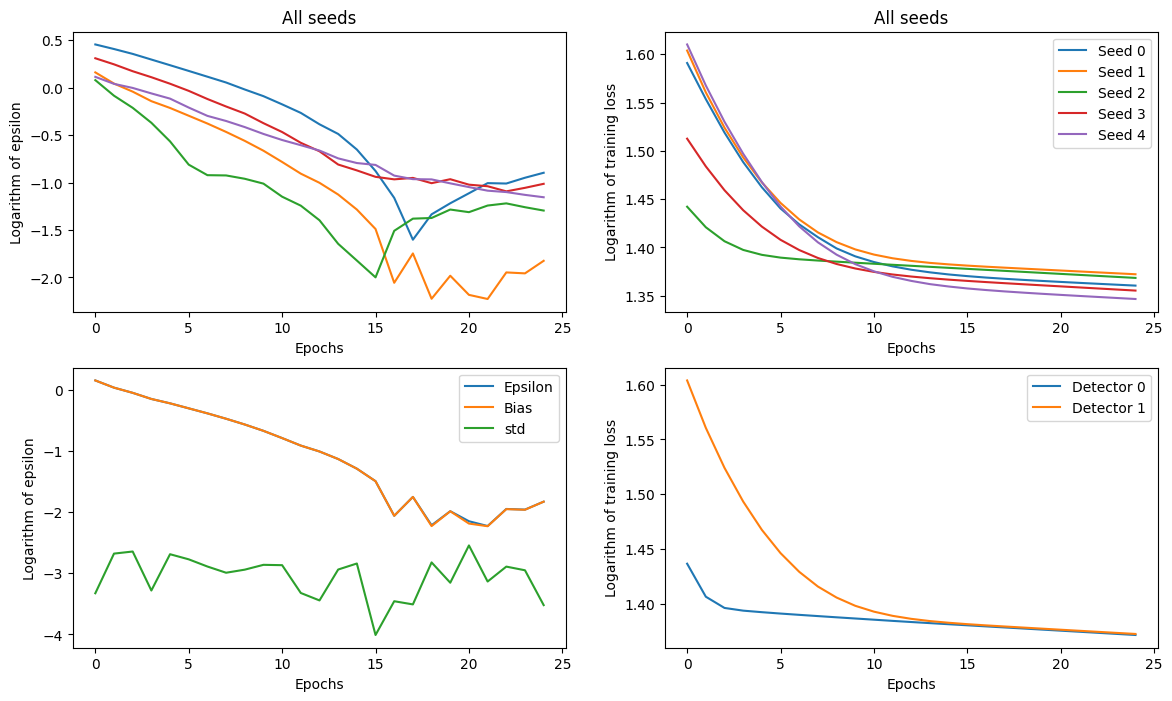

In [30]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 1

plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  #plt.plot(np.log10(epsilon[i,:]))
  plt.plot(np.log10(bias[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.206  FWHM(ns) = 0.000  std(ns) = 0.000
V55: CENTROID(ns) = -0.000  FWHM(ns) = 0.000  std(ns) = 0.000
V28: CENTROID(ns) = -0.206  FWHM(ns) = 0.000  std(ns) = 0.000


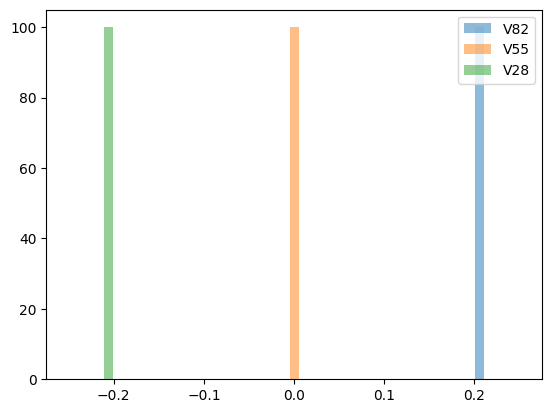

In [31]:
epoch = 21
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 51
histogN_V82, binsN, patchesN  = plt.hist(-1*(TOFN_V82_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range=[-0.25,0.25],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(TOFN_V55_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range=[-0.25,0.25],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(TOFN_V28_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]), bins = nbins,range=[-0.25,0.25],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

In [32]:
-1*(TOFN_V82_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:])Error_V82 = ( - 0.2)**2
Error_V55 = (-1*(TOFN_V55_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]))**2
Error_V28 = (-1*(TOFN_V28_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]) + 0.2)**2

Error = np.concatenate((Error_V82, Error_V55, Error_V28))
MSE = np.mean(Error)   
print(MSE)                                                                                                               

2.43636950326618e-05


# **ENSEMBLE MODEL**

In [33]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_V28 = np.average(np.squeeze(TOFN_V28_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V55 = np.average(np.squeeze(TOFN_V55_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V82 = np.average(np.squeeze(TOFN_V82_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)


V82: CENTROID(ns) = 0.220  FWHM(ns) = 0.000  std(ns) = 0.000
V55: CENTROID(ns) = -0.000  FWHM(ns) = 0.000  std(ns) = 0.000
V28: CENTROID(ns) = -0.188  FWHM(ns) = 0.000  std(ns) = 0.000


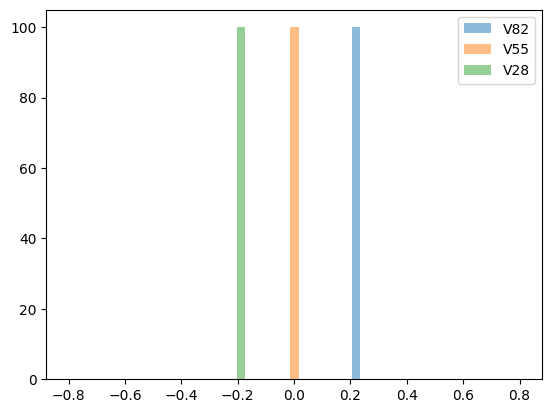

In [34]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(weighted_mean_V82) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(weighted_mean_V55) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(weighted_mean_V28) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))